In [94]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [95]:
emiss_lim_list = [""]

In [96]:
result_dir = Path.cwd().joinpath('Results')
result_dir.is_dir()

True

In [97]:
plots_dir = result_dir.joinpath('Plots')
Path.mkdir(plots_dir, exist_ok=True)

In [98]:
result_files_root = f"Primal_Baseline_noEmissLim"

In [99]:
def get_resource_types(df):
    # For each row in df, look at the "Resource" entry
    # and remove the number after the last underscore
    # to find the tech type.
    # Add the column of tech types to the df.
    tech_types = []
    for row in df.itertuples():
        tech_type = '_'.join(row.Resource.split('_')[:-1])
        tech_types.append(tech_type)
    df['ResourceType'] = tech_types
    return df


In [100]:
def get_resource_names(df, resource_names):
    tech_names = []
    for row in df.itertuples(): 
        tech_name = resource_names[row.ResourceType]
        tech_names.append(tech_name)
    df['ResourceName'] = tech_names
    return df


In [101]:
def get_zone_names(df, zone_names):
    zone_names_list = []
    for row in df.itertuples():
        zone_name = zone_names[row.Zone]
        zone_names_list.append(zone_name)
    df['ZoneName'] = zone_names_list
    return df

In [102]:
resource_names = {
    'res_hydro': 'Reservoir Hydro',
    'natural_gas': 'Natural Gas CombCycle',
    'natural_gas_ccs': 'Nat Gas CombCycle + CCS',
    'solar_pv': 'Solar PV',
    'battery': '4hr Li-ion',
    'offshore_wind': 'Offshore Wind',
    'onshore_wind': 'Onshore Wind',
    'ror_hydro': 'Run of River Hydro',
    'pumped_hydro': 'Pumped Hydro',
    'nuclear': 'Fission',
    'fusion': 'Fusion'
}

resource_colors = {
    'res_hydro': 'xkcd:sky blue',
    'natural_gas': 'xkcd:orange',
    'natural_gas_ccs': 'xkcd:aquamarine',
    'solar_pv': 'xkcd:yellowish',
    'battery': 'xkcd:dark grey',
    'offshore_wind': 'xkcd:robin\'s egg blue',
    'onshore_wind': 'xkcd:sage',
    'ror_hydro': 'xkcd:puce',
    'pumped_hydro': 'xkcd:light violet',
    'nuclear': 'xkcd:silver',
    'fusion': 'xkcd:reddish'
}

resource_colors_by_name = {
    resource_names[key]: color for key, color in resource_colors.items()
}

zone_names = {
    1.0: 'QC',
    2.0: 'ME',
    3.0: 'NH',
    4.0: 'VT',
    5.0: 'MA',
    6.0: 'RI',
    7.0: 'CT'    
}

line_names = {
    '1': 'QC->ME',
    '2': 'ME->NH',
    '3': 'NH->VT',
    '4': 'NH->MA',
    '5': 'VT->MA',
    '6': 'MA->RI',
    '7': 'MA->CT',
    '8': 'RI->CT',
}

In [103]:
result_df = {}
for emiss_lim in emiss_lim_list:
    result_df[emiss_lim] = {}

In [104]:
for emiss_lim in emiss_lim_list:
    result_files = result_dir.joinpath(f"{result_files_root}{emiss_lim}")

    df_capacity = pd.read_csv(result_files.joinpath("capacity.csv"))
    # Set any values below 0.1 to 0
    df_capacity.loc[df_capacity.EndCap <= 0.1, "EndCap"] = 0.0
    # Drop total in last row
    df_capacity = df_capacity.drop(df_capacity.index[-1])
    # Get tech types and add to DataFrame
    df_capacity = get_resource_types(df_capacity)
    df_capacity = get_resource_names(df_capacity, resource_names)
    df_capacity = get_zone_names(df_capacity, zone_names)

    # Make a new DataFrame with only the EndCa[] values, indexed by Zone and ResourceName, indexed by Zone
    df_capacity_by_zone = df_capacity.pivot(index='ZoneName', columns='ResourceName', values='EndCap')    
    df_capacity_by_zone = df_capacity_by_zone.fillna(0.0)

    result_df[emiss_lim]['capacity'] = df_capacity
    result_df[emiss_lim]['capacity_by_zone'] = df_capacity_by_zone

    result_df[emiss_lim]['capacity'] = df_capacity
    result_df[emiss_lim]['capacity_by_zone'] = df_capacity_by_zone

    df_power = pd.read_csv(result_files.joinpath("power.csv"))
    # Drop last column
    df_power = df_power.drop(df_power.columns[-1], axis=1)
    # Drop the first and second rows with zone and AnnualSum
    df_power = df_power.drop(df_power.index[[0, 1]])
    # Set the index to be from 1 : length of df_power
    df_power.index = range(1, len(df_power) + 1)
    # # Change the Resource column name to Time
    # df_power = df_power.rename(columns={'Resource': 'Time'})
    # Remove the Resource column
    df_power = df_power.drop('Resource', axis=1)
    # Set any values below 0.1 to 0
    df_power[df_power <= 0.1] = 0.0

    # Make a new empty DataFrame which is indexed by the zone names and the same column names as df_capacity_by_zone
    df_power_by_zone = pd.DataFrame(index=zone_names.values(), columns=df_capacity_by_zone.columns)
    # For each column of df_power, find the zone number based splitting the column name and taking the last element
    # then find the zone name based on the zone number
    # then find the tech type based on splitting the column name and taking all but the last element
    # then find the tech name based on the tech type
    # then add the value of the column to the correct row and column of df_power_by_zone
    for col_name in df_power.columns:
        zone = col_name.split('_')[-1]
        zone_name = zone_names[float(zone)]
        tech_type = '_'.join(col_name.split('_')[:-1])
        tech_name = resource_names[tech_type]
        df_power_by_zone.loc[zone_name,tech_name] = df_power[col_name].sum()
    # Fill any NaN values with 0.0
    df_power_by_zone = df_power_by_zone.fillna(0.0)

    result_df[emiss_lim]['power'] = df_power
    result_df[emiss_lim]['power_by_zone'] = df_power_by_zone

    df_flow = pd.read_csv(result_files.joinpath("flow.csv"))
    # Drop the first row
    df_flow = df_flow.drop(df_flow.index[0])
    # Drop the last column 
    df_flow = df_flow.drop(df_flow.columns[-1], axis=1)
    # Set the index to be from 1 : length of df_flow
    df_flow.index = range(1, len(df_flow) + 1)
    # Remove the Line column
    df_flow = df_flow.drop('Line', axis=1)
    # Rename the columns names using the line_names dictionary
    df_flow.rename(columns=line_names, inplace=True)

    result_df[emiss_lim]['flow'] = df_flow

# Calculate capacity factors and ISO-NE only generation

In [105]:
for emiss_lim in emiss_lim_list:
    # Divide the generations in df_power_by_zone by the capacities in df_capacity_by_zone to get the capacity factors
    df_cap_factor = 100.0 / 8760.0 * result_df[emiss_lim]['power_by_zone'].div(result_df[emiss_lim]['capacity_by_zone'])
    # Fill any NaN values with 0.0
    df_cap_factor = df_cap_factor.fillna(0.0)

    result_df[emiss_lim]['cap_factor'] = df_cap_factor

    QC_DEMAND = 217357818.5 # MWhe

    df_isone_power = result_df[emiss_lim]['power_by_zone'].copy()
    QC_gen = result_df[emiss_lim]['power_by_zone'].loc['QC','Reservoir Hydro']
    QC_trans = result_df[emiss_lim]['flow'].loc[:, 'QC->ME'].values
    QC_imports = np.sum(-QC_trans[QC_trans < 0.0])
    QC_exports = np.sum(QC_trans[QC_trans >= 0.0])

    # Reduce other gen by the amount imported to QC
    # Assume each generator does so equally
    gen_by_zone = df_isone_power.sum(axis=1)
    gen_except_QC = gen_by_zone.drop('QC')
    temp = np.sum(QC_imports) / np.sum(gen_except_QC)
    df_isone_power *= (1.0 - temp)

    df_isone_power.loc['QC','Reservoir Hydro'] = QC_exports

    df_isone_cap_factor = 100.0 / 8760.0 * df_isone_power.div(result_df[emiss_lim]['capacity_by_zone'])
    # Fill any NaN values with 0.0
    df_isone_cap_factor = df_isone_cap_factor.fillna(0.0)

    result_df[emiss_lim]['isone_power_by_zone'] = df_isone_power
    result_df[emiss_lim]['isone_cap_factor'] = df_isone_cap_factor

# Write summaries to CSV

In [106]:
summaries = {
    'power_by_zone': 'summ_power_by_zone.csv',
    'capacity_by_zone': 'summ_capacity_by_zone.csv',
    'cap_factor': 'summ_cap_factor.csv',
    'isone_power_by_zone': 'summ_isone_power_by_zone.csv',
    'isone_cap_factor': 'summ_isone_cap_factor.csv',
}
for emiss_lim in emiss_lim_list:
    for summary, file_name in summaries.items():
        summ_dir = result_dir.joinpath("summaries", summary)
        Path.mkdir(summ_dir, exist_ok=True, parents=True)
        result_df[emiss_lim][summary].to_csv(summ_dir.joinpath(f"EmissLevel_{emiss_lim}_{file_name}"), index=True)

In [107]:
def json_2_results(json_file):
    result_df = {}
    with open(json_file) as f:
        data = json.load(f)
    for key, value in data.items():
        result_df[float(key)] = pd.DataFrame(value)
    return result_df

In [108]:
def results_2_json_dict(result_df):
    # For each entry in result_df, resursively check if it's a DataFrame.
    # If it is, use pd.to_json() to convert it to a string
    # If it's not, return the entry as is.
    # Return a dictionary of the results.
    result_dict = {}
    for emiss_lim, value in result_df.items():
        result_dict[emiss_lim] = {}
        for key2, value2 in value.items():
            if isinstance(value2, pd.DataFrame):
                result_dict[emiss_lim][key2] = value2.to_json()
            else:
                result_dict[emiss_lim][key2] = value2
    return result_dict

In [109]:
# ## Write result_df to a json file
# result_dict = results_2_json_dict(result_df)
# with open(result_dir.joinpath('result_df.json'), 'w') as fp:
#     json.dump(result_dict, fp, indent=4) 

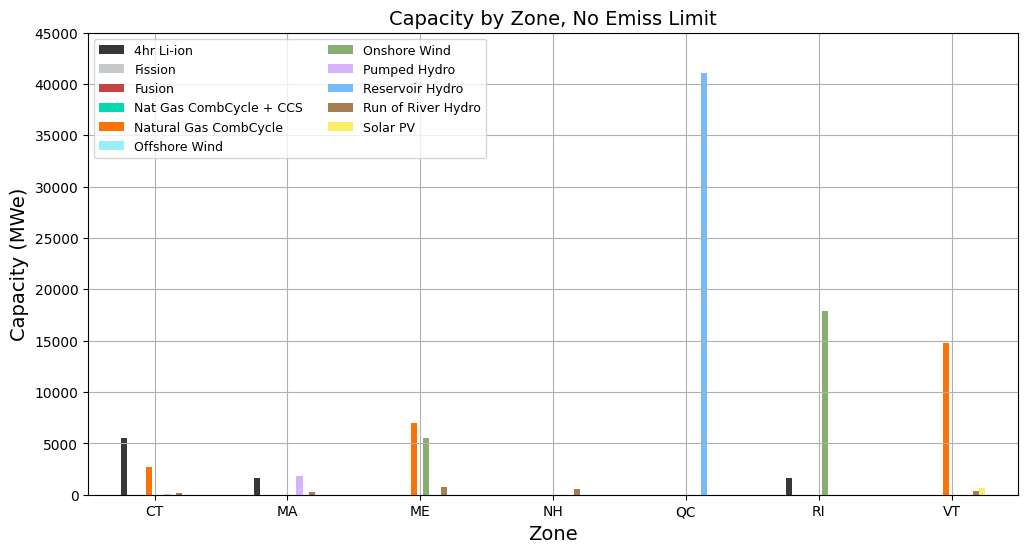

In [110]:
temp_plot_dir = plots_dir.joinpath("capacity_by_zone")
Path.mkdir(temp_plot_dir, exist_ok=True, parents=True)

for emiss_lim in emiss_lim_list:
    df_capacity_by_zone =  result_df[emiss_lim]['capacity_by_zone']

    fig, ax = plt.subplots(figsize=(12, 6))
    df_capacity_by_zone.plot.bar(ax=ax, rot=0, color=resource_colors_by_name)
    ax.set_ylabel('Capacity (MWe)', fontsize=14)
    ax.set_xlabel('Zone', fontsize=14)
    ax.set_title(f"Capacity by Zone, No Emiss Limit", fontsize=14)
    ax.grid(True)
    ax.set_ylim([0, 45e3])
    ax.legend(ncols=2, fontsize=9)
    fig.savefig(temp_plot_dir.joinpath(f"Capacity_by_Zone_co2_{emiss_lim}.png"), dpi=300)

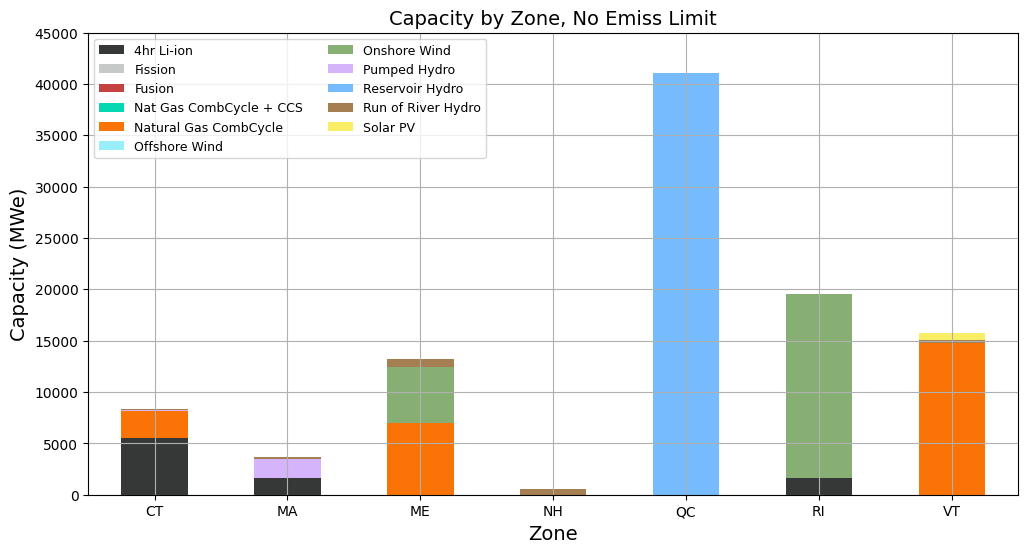

In [111]:
temp_plot_dir = plots_dir.joinpath("stacked_capacity_by_zone")
Path.mkdir(temp_plot_dir, exist_ok=True)

for emiss_lim in emiss_lim_list:
    df_capacity_by_zone =  result_df[emiss_lim]['capacity_by_zone']

    fig, ax = plt.subplots(figsize=(12, 6))
    df_capacity_by_zone.plot.bar(ax=ax, stacked=True, rot=0, color=resource_colors_by_name)
    ax.set_ylabel('Capacity (MWe)', fontsize=14)
    ax.set_xlabel('Zone', fontsize=14)
    ax.set_title(f"Capacity by Zone, No Emiss Limit", fontsize=14)
    ax.grid(True)
    ax.legend(ncols=2, fontsize=9)
    ax.set_ylim([0, 45e3])
    fig.savefig(temp_plot_dir.joinpath(f"Stacked_Capacity_by_Zone_co2_{emiss_lim}.png"), dpi=300)

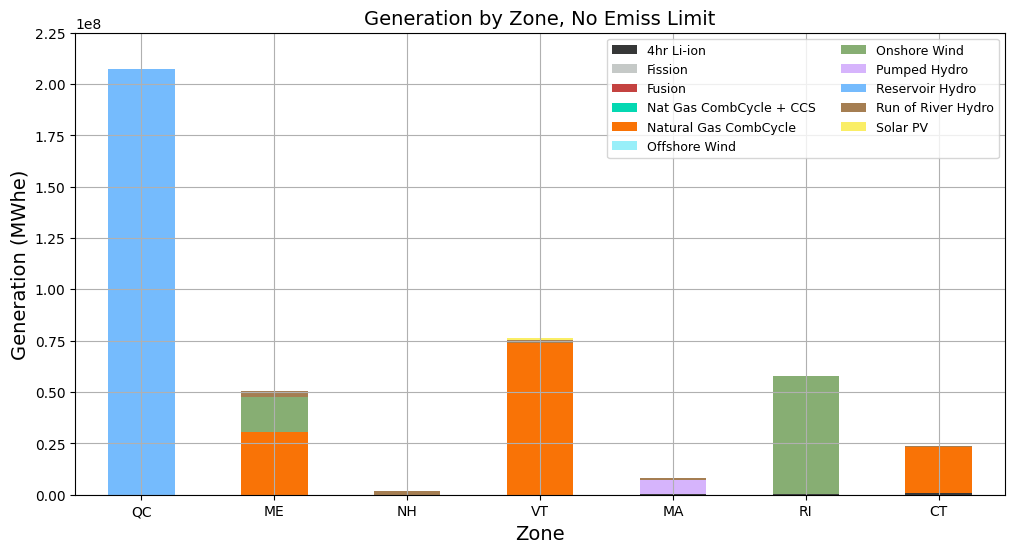

In [112]:
temp_plot_dir = plots_dir.joinpath("gen_by_zone")
Path.mkdir(temp_plot_dir, exist_ok=True)

for emiss_lim in emiss_lim_list:
    df_capacity_by_zone =  result_df[emiss_lim]['power_by_zone']

    fig, ax = plt.subplots(figsize=(12, 6))
    df_capacity_by_zone.plot.bar(ax=ax, stacked=True, rot=0, color=resource_colors_by_name)
    ax.set_ylabel('Generation (MWhe)', fontsize=14)
    ax.set_xlabel('Zone', fontsize=14)
    ax.set_title(f"Generation by Zone, No Emiss Limit", fontsize=14)
    ax.grid(True)
    ax.legend(ncols=2, fontsize=9)
    ax.set_ylim([0, 2.25e8])
    fig.savefig(temp_plot_dir.joinpath(f"Gen_by_Zone_co2_{emiss_lim}.png"), dpi=300)

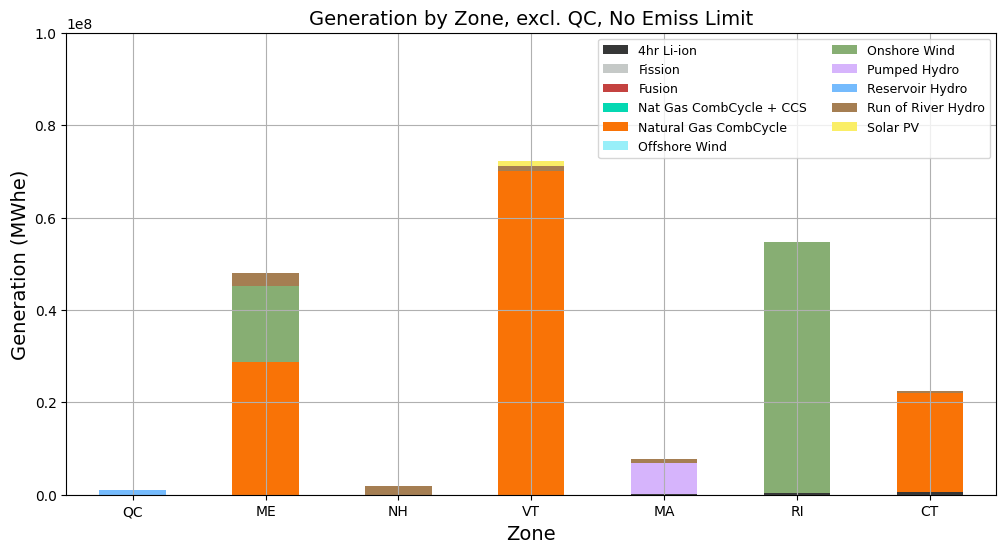

In [113]:
temp_plot_dir = plots_dir.joinpath("isone_gen_by_zone")
Path.mkdir(temp_plot_dir, exist_ok=True)

for emiss_lim in emiss_lim_list:
    df_capacity_by_zone =  result_df[emiss_lim]['isone_power_by_zone']

    fig, ax = plt.subplots(figsize=(12, 6))
    df_capacity_by_zone.plot.bar(ax=ax, stacked=True, rot=0, color=resource_colors_by_name)
    ax.set_ylabel('Generation (MWhe)', fontsize=14)
    ax.set_xlabel('Zone', fontsize=14)
    ax.set_title(f"Generation by Zone, excl. QC, No Emiss Limit", fontsize=14)
    ax.grid(True)
    ax.legend(ncols=2, fontsize=9)
    ax.set_ylim([0, 1e8])
    fig.savefig(temp_plot_dir.joinpath(f"ISONE_Gen_by_Zone_co2_{emiss_lim}.png"), dpi=300)

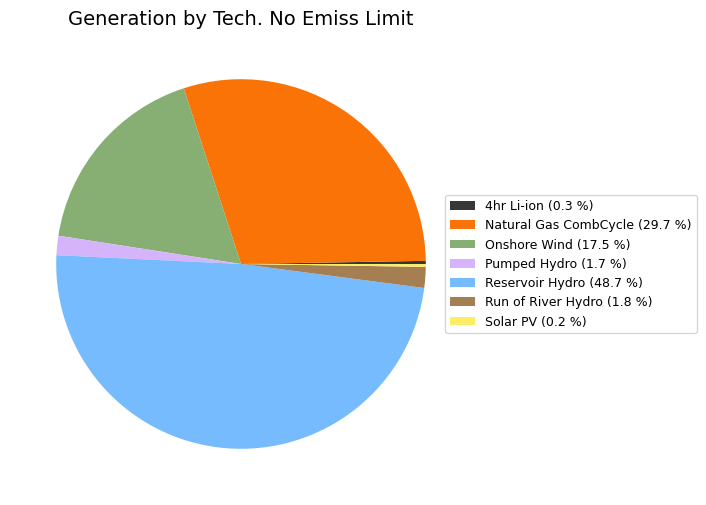

In [114]:
temp_plot_dir = plots_dir.joinpath("gen_by_tech")
Path.mkdir(temp_plot_dir, exist_ok=True)

for emiss_lim in emiss_lim_list:
    df_gen_by_zone = result_df[emiss_lim]['power_by_zone']

    gen_sum = df_gen_by_zone.sum()
    gen_sum = gen_sum.loc[gen_sum>0]
    gen_sum_colors = [resource_colors_by_name[tech] for tech in gen_sum.index]
    gen_percent = gen_sum / gen_sum.sum() * 100.0
    
    fig, ax = plt.subplots(figsize=(12, 6))
    gen_sum.plot.pie(ax=ax, colors=gen_sum_colors, labeldistance=None)
    labels = [f"{tech} ({gen_percent[tech]:.1f} %)" for tech, cap in gen_sum.items()]
    ax.legend(labels, loc='right', bbox_to_anchor=(1.5, 0.5), fontsize=9)
    ax.set_title(f"Generation by Tech. No Emiss Limit", fontsize=14)
    fig.savefig(temp_plot_dir.joinpath(f"Gen_by_Tech_co2_{emiss_lim}.png"), dpi=300)

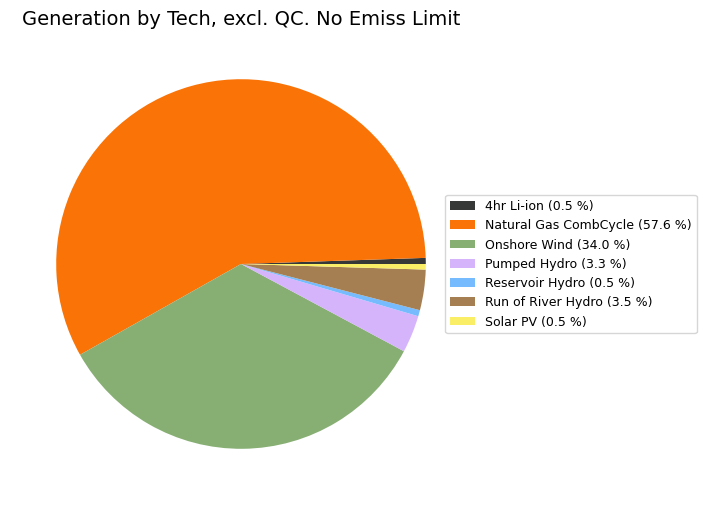

In [117]:
temp_plot_dir = plots_dir.joinpath("isone_gen_by_tech")
Path.mkdir(temp_plot_dir, exist_ok=True)

for emiss_lim in emiss_lim_list:
    df_gen_by_zone =  result_df[emiss_lim]['isone_power_by_zone']

    gen_sum = df_gen_by_zone.sum()
    gen_sum = gen_sum.loc[gen_sum>0]
    gen_sum_colors = [resource_colors_by_name[tech] for tech in gen_sum.index]
    gen_percent = gen_sum / gen_sum.sum() * 100.0
    
    fig, ax = plt.subplots(figsize=(12, 6))
    gen_sum.plot.pie(ax=ax, colors=gen_sum_colors, labeldistance=None)
    labels = [f"{tech} ({gen_percent[tech]:.1f} %)" for tech, cap in gen_sum.items()]
    ax.legend(labels, loc='right', bbox_to_anchor=(1.5, 0.5), fontsize=9)
    ax.set_title(f"Generation by Tech, excl. QC. No Emiss Limit", fontsize=14)
    fig.savefig(temp_plot_dir.joinpath(f"ISONE_Gen_by_Tech_co2_{emiss_lim}.png"), dpi=300)

# Plot sorted QC -> ME transmission

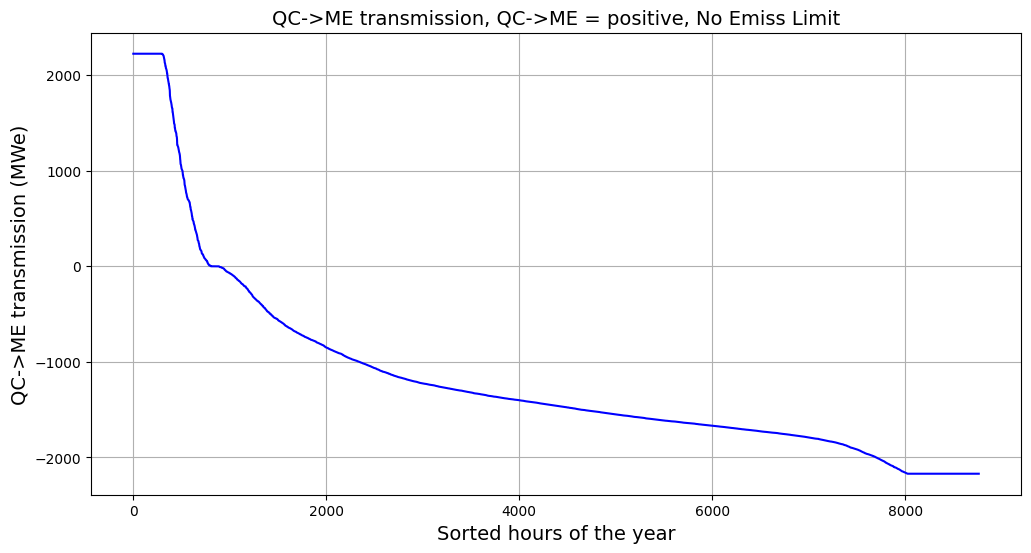

In [116]:
temp_plot_dir = plots_dir.joinpath("QC_2_ME_trans")
Path.mkdir(temp_plot_dir, exist_ok=True)

for emiss_lim in emiss_lim_list:
    df_flow =  result_df[emiss_lim]['flow']
    sorted_qc_2_me = df_flow.loc[:,'QC->ME'].sort_values(ascending=False)
    # Reset index to be from 1 : length of df_flow
    sorted_qc_2_me.index = range(1, len(sorted_qc_2_me) + 1)
    fig, ax = plt.subplots(figsize=(12, 6))
    sorted_qc_2_me.plot(ax=ax, color='blue')
    ax.set_xlabel('Sorted hours of the year', fontsize=14)
    ax.set_ylabel('QC->ME transmission (MWe)', fontsize=14)
    ax.set_title(f"QC->ME transmission, QC->ME = positive, No Emiss Limit", fontsize=14)
    ax.grid(True)
    fig.savefig(temp_plot_dir.joinpath(f"QC_2_ME_trans_{emiss_lim}.png"), dpi=300)